In [1]:
import osmnx as ox
import datetime
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import pickle

ox.config(log_console=True, use_cache=True)
weight_by_length = False
ox.__version__

'0.16.1'

# Prepare Data
- Download and save data by osmnx.
- If a city has been saved, load it locally without downloading.

In [5]:
places = {
"Toronto": "Toronto, CA",
"Montreal": "Montreal, CA",
"Vancouver": "Vancouver, CA",
"Calgary": "Calgary, CA",
"Edmonton": "Edmonton, CA",
"Ottawa": "Ottawa, CA",
"Gatineau":"Gatineau, CA",
"Winnipeg": "Winnipeg, CA",
"Quebec City": "Quebec City, CA",
"Hamilton": "Hamilton, CA",
"Kitchener": "Kitchener, CA",
"London": "London, CA",
"Victoria": "Victoria, CA",
"Halifax": "Halifax, CA",
"Oshawa": "Oshawa, CA",
"Windsor": "Windsor, CA",
"Saskatoon": "Saskatoon, CA",
"St. Catharines": "St. Catharines, CA",
"Regina": "Regina, CA",
"St. John's": "St. John's, CA",
"Kelowna": "Kelowna, CA",
"Barrie": "Barrie, CA",
"Sherbrooke": "Sherbrooke, CA",
"Guelph": "Guelph, CA",
"Abbotsford": "Abbotsford, CA",
"Kingston": "Kingston, CA",
"Kanata": "Kanata, Ontario, CA",
"Trois-Rivières": "Trois-Rivières, Quebec, CA",
"Moncton": "Moncton, CA",
"Chicoutimi–Jonquière": "Chicoutimi–Jonquière, CA",
}

# places = {
# "Chicoutimi–Jonquière": "Chicoutimi–Jonquière, CA",
# "Milton": "Milton, CA"
# "Guelph": "Guelph, CA",
# "Kanata": "Kanata, CA",
# }

bearings = {}

try:
    with open('data.pickle', 'rb') as f:
        Gs = pickle.load(f)
except FileNotFoundError:
        Gs ={}

for place in sorted(places.keys()):
    print(datetime.datetime.now(), place)
    
    # get the graph
    query = places[place]
    if place not in Gs.keys():
        try:
            G = ox.graph_from_place(query, network_type='drive')
        except:
            try:
                G = ox.graph_from_place(query, network_type='drive', which_result=2)
            except:
                G = ox.graph_from_place(query, network_type='drive', which_result=3)
        Gs[place] = G
        ox.save_graph_shapefile(G, place)
        with open('data.pickle', 'wb') as f:
            pickle.dump(Gs, f)


    
# projection of graph
try:
    with open('projected_data.pickle', 'rb') as f:
        proj_dict = pickle.load(f)
except FileNotFoundError:
    proj_dict ={}

for place in Gs:
    if place not in proj_dict.keys():
        proj_dict[place] = ox.project_graph(Gs[place])
        print(place)
        with open('projected_data.pickle', 'wb') as f:
            pickle.dump(proj_dict, f)

2020-10-21 18:39:30.489465 Abbotsford
2020-10-21 18:39:30.490462 Barrie
2020-10-21 18:39:30.490462 Calgary
2020-10-21 18:39:30.492456 Chicoutimi–Jonquière
2020-10-21 18:39:30.492456 Edmonton
2020-10-21 18:39:30.493454 Gatineau
2020-10-21 18:39:30.493454 Guelph
2020-10-21 18:39:30.493454 Halifax
2020-10-21 18:39:30.493454 Hamilton
2020-10-21 18:39:30.493454 Kanata
2020-10-21 18:39:30.493454 Kelowna
2020-10-21 18:39:30.493454 Kingston
2020-10-21 18:39:30.493454 Kitchener
2020-10-21 18:39:30.493454 London
2020-10-21 18:39:30.493454 Moncton
2020-10-21 18:39:30.493454 Montreal
2020-10-21 18:39:30.493454 Oshawa
2020-10-21 18:39:30.493454 Ottawa
2020-10-21 18:39:30.493454 Quebec City
2020-10-21 18:39:30.493454 Regina
2020-10-21 18:39:30.493454 Saskatoon
2020-10-21 18:39:30.493454 Sherbrooke
2020-10-21 18:39:30.493454 St. Catharines
2020-10-21 18:39:30.493454 St. John's
2020-10-21 18:39:30.493454 Toronto
2020-10-21 18:39:30.493454 Trois-Rivières
2020-10-21 18:39:30.493454 Vancouver
2020-10-21 

# Calculate basic statistics

In [9]:
def get_av(G):
    G1 = ox.get_undirected(G)
    total_degree = []
    for _, degree  in G1.degree:
        total_degree.append(degree)
    return sum (total_degree)/len (total_degree)


# show some basic stats about the network connectivity
summary = {
'n': [],
'm': [],
'k_avg': [],
'intersection_count': [],
'streets_per_node_avg': [],
'streets_per_node_counts': [] ,
'streets_per_node_proportion': [],
'edge_length_total': [],
'edge_length_avg': [],
'street_length_total': [],
'street_length_avg': [],
'street_segments_count': [],
'node_density_km': [],
'intersection_density_km': [],
'edge_density_km': [],
'street_density_km': [],
'circuity_avg': [],
'self_loop_proportion': [],
'clean_intersection_count': [],
'clean_intersection_density_km': []}
areas = []
av_node_d = []

# area_square meters
for place in proj_dict:
    nodes_proj = ox.graph_to_gdfs(proj_dict[place], edges=False)
    proj_dict[place].graph_area_m = nodes_proj.unary_union.convex_hull.area


for place in proj_dict:
    basic_info = ox.basic_stats(proj_dict[place], area = proj_dict[place].graph_area_m, clean_intersects=True, circuity_dist='euclidean')
    for feature in summary.keys():
        summary[feature].append(basic_info[feature])
    areas.append(proj_dict[place].graph_area_m)
    av_node_d.append(get_av(proj_dict[place]))


summary = pd.DataFrame(data = summary, 
                 index= places.keys())

summary['areas'] = areas
summary['average_node_degree'] = av_node_d
# summary.to_csv('result1.csv', sep=';')
s = summary[['average_node_degree',
             'street_length_avg',
             'street_density_km',
             'circuity_avg',
             'intersection_density_km']].copy()
s['beta'] = summary['m']/summary['n']
s['gamma'] = summary['m']/(3*(summary['n']-2))
# s=s.iloc[0:-1,:]
s

,average_node_degree,street_length_avg,street_density_km,circuity_avg,intersection_density_km,beta,gamma
Toronto,2.579327,247.048945,2567.111224,1.057047,5.846812,2.327524,0.776308
Montreal,2.934181,198.314525,5231.278549,1.112345,15.792938,2.849750,0.950780
Vancouver,2.971026,136.726164,7398.988341,1.159576,31.624409,2.362129,0.787423
Calgary,2.822232,202.574374,1693.663637,1.106284,4.988660,2.598530,0.866973
Edmonton,2.953059,152.504634,5575.565326,1.116984,20.855822,2.503858,0.834691
Ottawa,2.941631,177.971643,4825.986616,1.143767,16.448127,2.694240,0.898775
Gatineau,2.936249,148.274610,6394.363708,1.108493,25.988315,2.697554,0.899852
Winnipeg,2.904762,135.501828,6186.460614,1.083571,26.867430,2.531162,0.844312
Quebec City,2.846613,194.038310,2510.398855,1.056246,7.537523,2.597630,0.866026
Hamilton,2.916751,183.566786,3494.236700,1.206782,11.773620,2.591878,0.864837


# Cluster analysis

In [10]:
# normornize indices
n_s=(s-s.min())/(s.max()-s.min())
n_s

,average_node_degree,street_length_avg,street_density_km,circuity_avg,intersection_density_km,beta,gamma
Toronto,0.000000,1.000000,0.085178,0.205966,0.024028,0.000000,0.000000
Montreal,0.470176,0.642532,0.344986,0.499209,0.189890,0.742643,0.744952
Vancouver,0.518996,0.190781,0.556379,0.749670,0.453895,0.049211,0.047459
Calgary,0.321846,0.673778,0.000000,0.467065,0.009718,0.385390,0.387118
Edmonton,0.495190,0.306516,0.378560,0.523808,0.274318,0.250760,0.249280
Ottawa,0.480048,0.493317,0.305462,0.665834,0.200816,0.521497,0.522904
Gatineau,0.472917,0.275489,0.458409,0.478780,0.359908,0.526209,0.527501
Winnipeg,0.431197,0.181800,0.438134,0.346622,0.374568,0.289588,0.290361
Quebec City,0.354150,0.611166,0.079647,0.201719,0.052222,0.384109,0.383076
Hamilton,0.447082,0.534357,0.175591,1.000000,0.122864,0.375930,0.377999


In [ ]:
# cluster analysis
%matplotlib inline
from scipy.cluster import hierarchy
import scipy.cluster.hierarchy as sch

Y3 = sch.linkage(n_s, metric='euclidean', method='ward')
# sns.set_palette('tab10')
# hierarchy.set_link_color_palette(list(sns.color_palette().as_hex()))
# color_palette = [matplotlib.colors.rgb2hex(i) for i in plt.get_cmap('Set1').colors]
# color_palette = ['C0','C3','C2']
# hierarchy.set_link_color_palette(color_palette)
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_axes([0.18, 0.55, 0.72, 0.45], frame_on=False)
with plt.rc_context({'lines.linewidth': 1}):
    Z3 = sch.dendrogram(Y3, above_threshold_color='black', color_threshold=0.5*max(Y3[:,2]))

ax1.set_xticks([])
ax1.set_yticks([])
axc = fig.add_axes([0.92, 0.27, 0.02, 0.28])

ax2 = fig.add_axes([0.18, 0.27, 0.72, 0.28])
c = ax2.imshow(n_s.iloc[Z3['leaves'],:].values.T, aspect='auto')
ax2.set_xticks(range(n_s.shape[0]))
ax2.set_xticklabels(summary.index[Z3['leaves']], rotation=90)
ax2.set_yticks(range(n_s.shape[1]))
ax2.set_yticklabels(n_s.columns)
plt.colorbar(c, axc)

In [27]:
fig.savefig('cluster.pdf')

# Street Orientation Analysis

In [28]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [29]:
# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color='#003366', edgecolor='k', linewidth=0.5, alpha=0.7)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'Century Gothic', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'Century Gothic', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'Century Gothic', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

<ipython-input-29-c7339239722f>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)


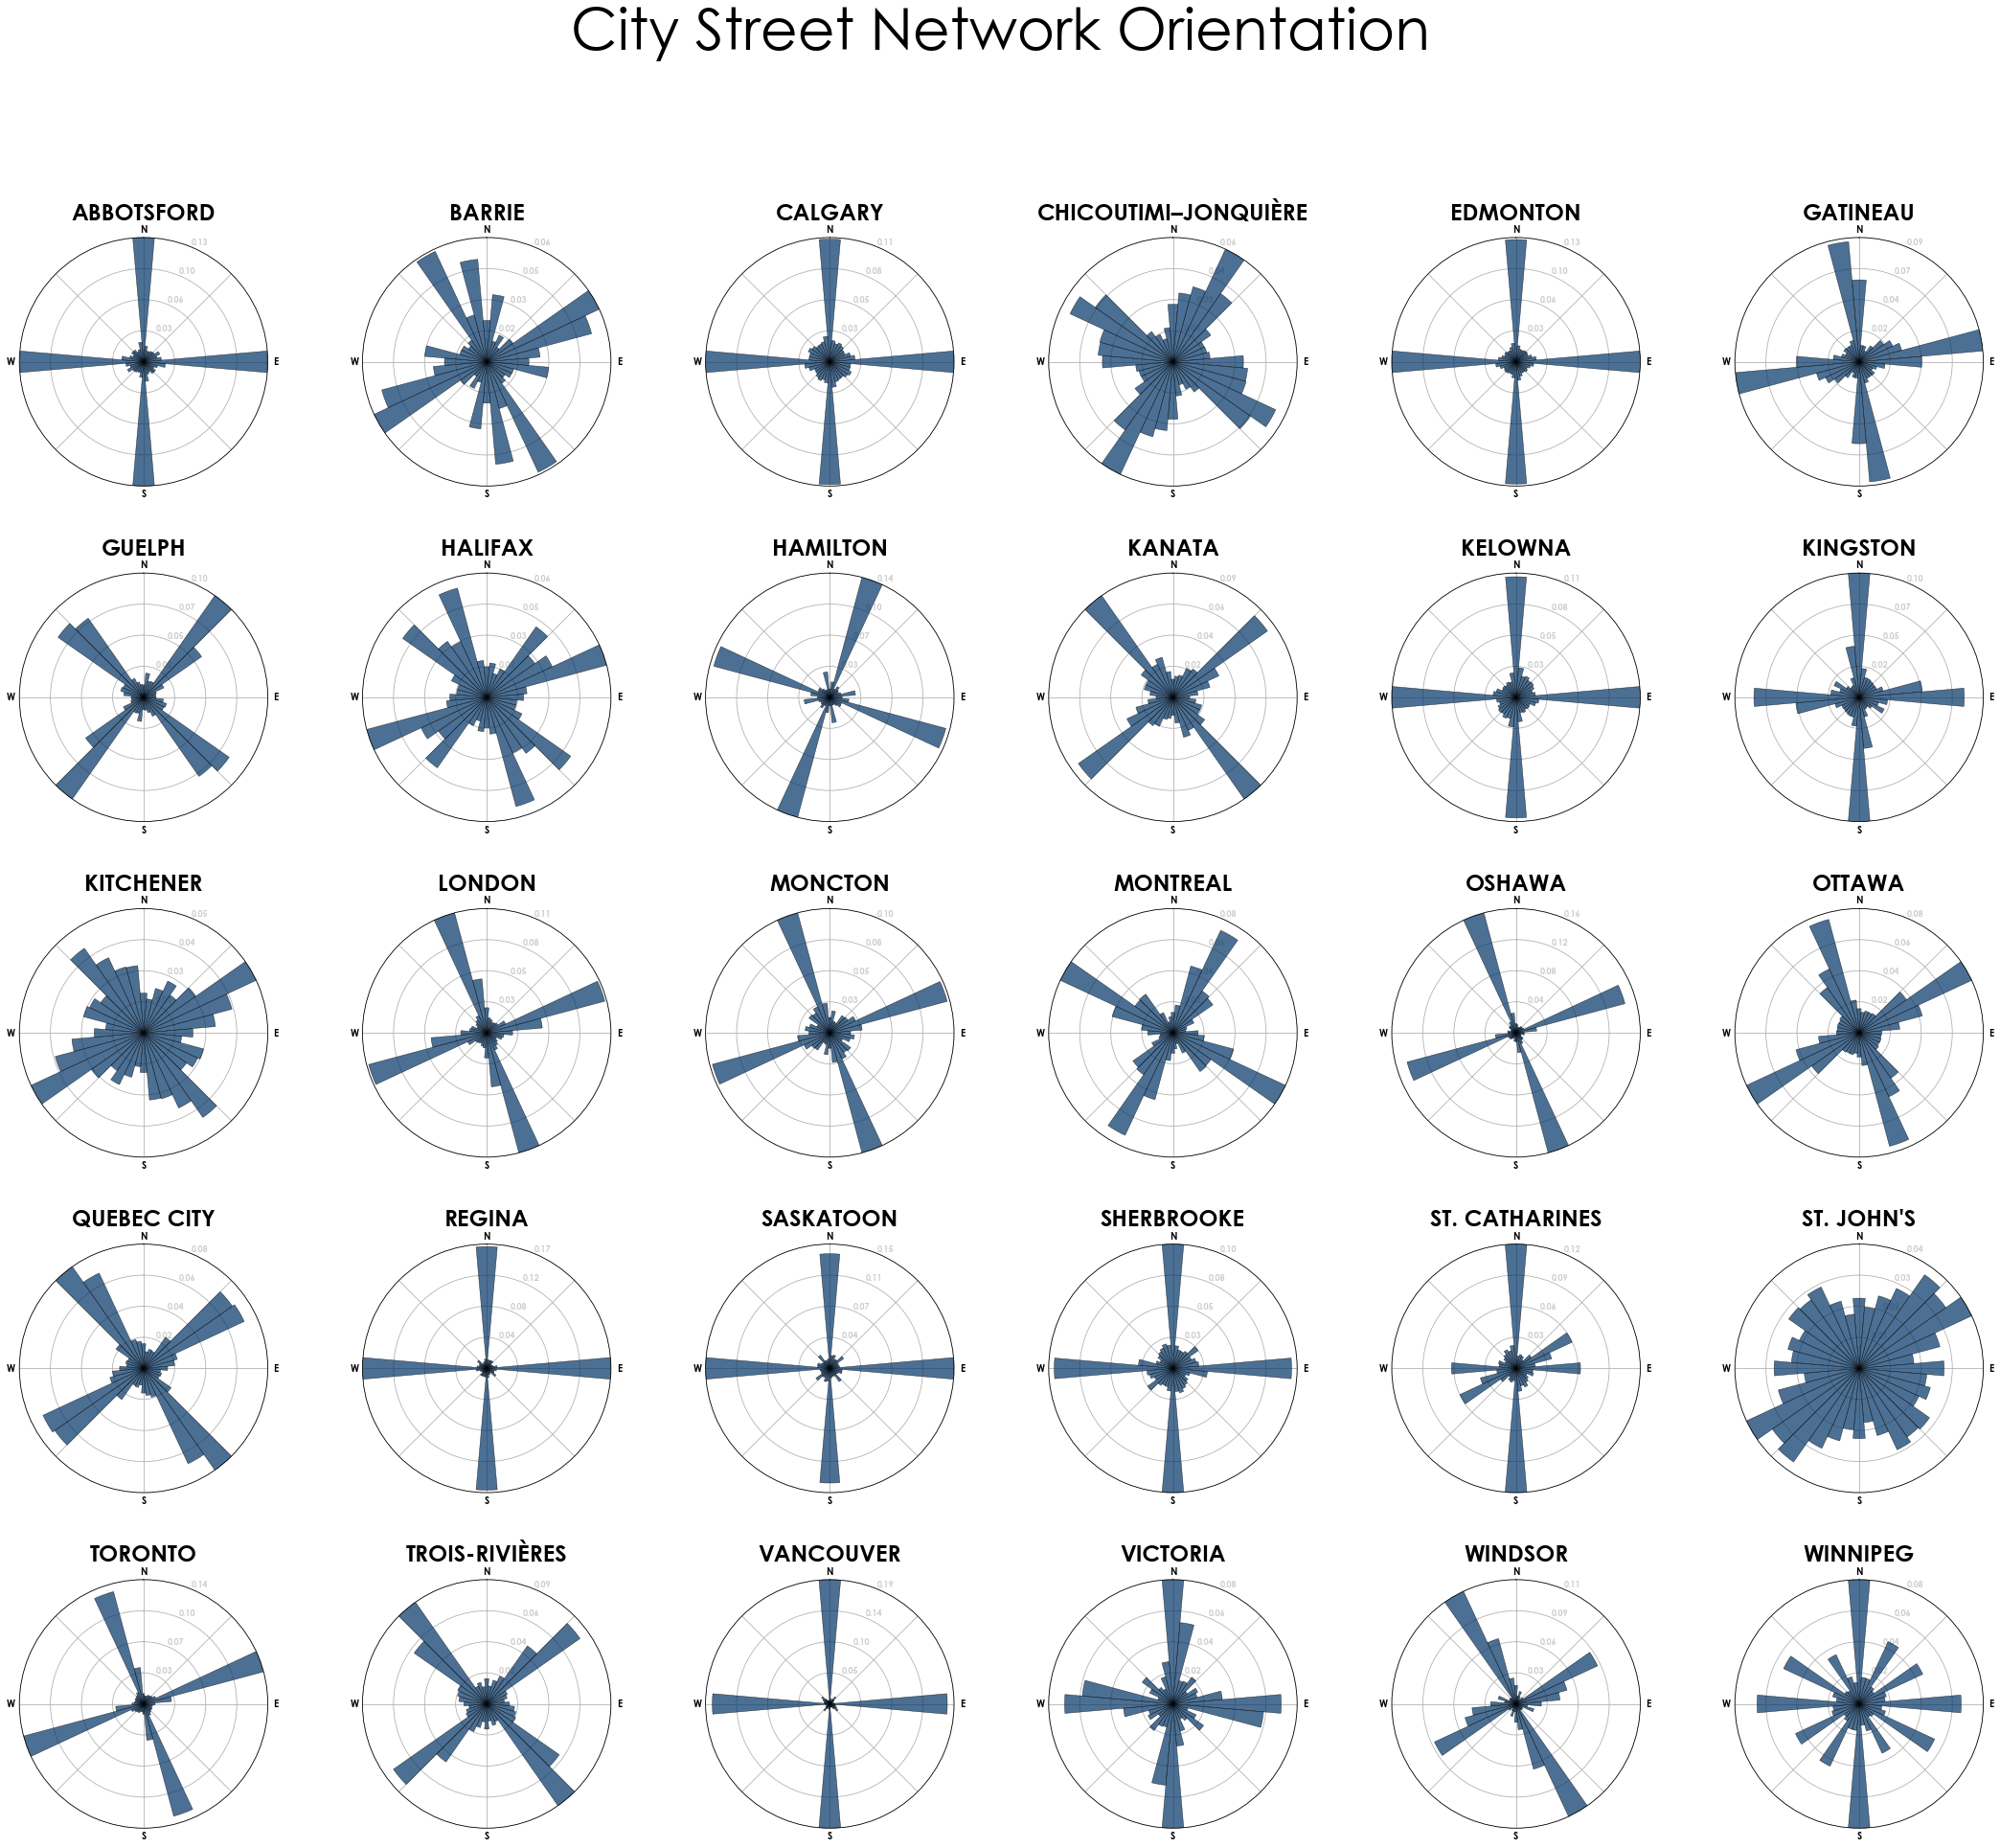

In [30]:
with open('data.pickle', 'rb') as f:
    Gs = pickle.load(f)

bearings = {}
for place in sorted(places.keys()):    
    # calculate edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(Gs[place]))
    
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')

        
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig1, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    polar_plot(ax, bearings[place].dropna(), title=place)

# add super title and save full image
suptitle_font = {'family':'Century Gothic', 'fontsize':60, 'fontweight':'normal', 'y':1.07}
fig1.suptitle('City Street Network Orientation', **suptitle_font)
fig1.tight_layout()
fig1.subplots_adjust(hspace=0.35)
fig1.savefig('images/street-orientations.png', dpi=120, bbox_inches='tight')
# plt.close()